 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 5: Optimisation avec contraintes et calcul variationnel
Tangi Migot et Paul Raynaud

In [2]:
pwd() # te dis ou tu te situes
using Pkg
Pkg.activate(".") # activate l'endroit où t'es
Pkg.status()

  Activating project at `~/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5`


Status `~/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Project.toml`
  [54578032] ADNLPModels v0.7.0
⌅ [56d4f2e9] Gridap v0.15.5
  [7073ff75] IJulia v1.24.2
  [ba0b0d4f] Krylov v0.9.5
  [a4795742] NLPModels v0.20.0
  [f4238b75] NLPModelsIpopt v0.10.1
  [80da258d] PDENLPModels v0.3.4
  [ff4d7338] SolverCore v0.3.7
  [37e2e46d] LinearAlgebra
  [56ddb016] Logging
  [de0858da] Printf
  [8dfed614] Test
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [3]:
using Krylov, LinearAlgebra, Logging, NLPModels, NLPModelsIpopt, Printf, SolverCore, Test

In [7]:
using PDENLPModels, Gridap

## Quelques commentaires en Julia

### Les kwargs: choix optionnels

Dans le projet du dernier labo, une des questions demandait d'ajouter une option pour utiliser la fonction `lsmr` ou `lsqr`. C'est le cas typique d'arguments optionnels:
- On veut proposer un choix par défaut à l'utilisateur, par exemple `lsqr`;
- On veut laisser la possibilité à l'utilisateur de changer;
- On voudrait aussi pouvoir ajouter d'autres par la suite (sans avoir à tout modifier).

In [59]:
function dsol(A, b, ϵ; solver :: Function = lsqr)
    (d, stats) = solver(A, b, atol = ϵ)
    return d
end

dsol (generic function with 1 method)

A noter que l'on donne des valeurs par défaut aux arguments qui apparaissent après le `;`.

## Exercice 1: Pénalité quadratique pour les ADNLPModels

Dans cet exercice, on va étudier une version simple d'une méthode de pénalité quadratique pour les problèmes d'optimisation avec contraintes d'égalité.
```math
min f(x) s.à c(x) = 0.
```
Dans les labos précédents, on a déjà utilisé un NLPModel particulier, le ADNLPModel:

In [60]:
using ADNLPModels, LinearAlgebra, Test
fH(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H = [10., 20.]
cH(x) = [x[1]-1]
himmelblau = ADNLPModel(fH, x0H, cH, [0.], [0.])

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  ForwardDiffADJprod,
  ForwardDiffADJtprod,
  ForwardDiffADJacobian,
  ForwardDiffADHessian,
  ForwardDiffADGHjvprod,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ████████████████████ 1     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ████████████████████ 1     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
     

Attention: dans toute la suite de l'exercice on suppose que les bornes sur les contraintes `nlp.meta.lcon` et `nlp.meta.ucon` sont 0 pour simplifier.

### Question 1: Transformer un ADNLPModel en un problème pénalisé
Coder la fonction `quad_penalty_adnlp` qui prend en entrée un ADNLPModel, et un paramètre ρ et qui retourne un nouveau ADNLPModel qui correspond au problème sans contrainte:
$$
\min_x f(x) + \frac{\rho}{2}\|c(x)\|^2.
$$
Remarque: on peut accèder aux fonctions f et c par `NLPModels.obj()` et `NLPModels.cons()`.

In [61]:
function quad_penalty_adnlp(nlp :: ADNLPModel, ρ :: Real)
    f = x -> NLPModels.obj(nlp,x)
    c = x -> NLPModels.cons(nlp,x)
    f_quad = x -> f(x) + (ρ/2) * norm(c(x))^2
    nlp_quad = ADNLPModel(f_quad, nlp.meta.x0)
   return nlp_quad
end

quad_penalty_adnlp (generic function with 1 method)

In [62]:
# Faire des tests pour vérifier que ça fonctionne.

# fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
# x0H = [10., 20.]
# himmelblau = ADNLPModel(fH, x0H)

In [63]:
himmelblau_quad = quad_penalty_adnlp(himmelblau, 1)
@test himmelblau_quad.meta.ncon == 0
@test obj(himmelblau_quad, zeros(2)) == 170.5

Test Passed

In [64]:
#Ajouter au moins un autre test similaire avec des contraintes.
ftest(x) = (x[1] + x[2])^2 - (x[1]+x[2])
x0t = [0., 0.]
ct(x) = [x[1]^2 + x[1]]
nlp_test = ADNLPModel(ftest, x0t, ct, [0.], [0.])
nlp_test_quad = quad_penalty_adnlp(nlp_test,1)

@test nlp_test_quad.meta.ncon == 0
@test obj(nlp_test_quad, x0t) == obj(nlp_test_quad, x0t)

Test Passed

In [65]:
# Ajouter un test au cas ou `nlp.meta.lcon` ou `nlp.meta.ucon` ont des composantes differentes de 0.

@test  isempty(himmelblau_quad.meta.lcon)
@test  isempty(himmelblau_quad.meta.ucon)

Test Passed

### Question 2: KKT
Coder une fonction `KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ)` qui vérifie si le point `x` avec multiplicateur de Lagrange `λ` satisfait les conditions KKT d'un problème avec contraintes d'égalités.

In [66]:
function KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ; ϵ=10^(-10))
   grad_f = grad(nlp,x)
   jac_c = jac(nlp,x)
   test1 = isapprox(grad_f, jac_c'*λ, atol=ϵ)
   test2 = isapprox(cons(nlp,x), zeros(length(λ)), atol=ϵ)
   return test1 && test2
end

KKT_eq_constraint (generic function with 1 method)

In [67]:
# test
gtest(x) = x[1] + x[2]
x0t = [0., 0.]
ct(x) = [(x[1]^2) + (x[2]^2)-1]
nlp_test = ADNLPModel(gtest, x0t, ct, [0.], [0.])

x_t = [1/sqrt(2),1/sqrt(2)]
λ_t = 1/sqrt(2)

@test KKT_eq_constraint(nlp_test,x_t,λ_t)

Test Passed

### Question 3: méthode de pénalité quadratique

In [68]:
using NLPModelsIpopt

In [69]:
function quad_penalty(nlp      :: AbstractNLPModel,
                      x        :: AbstractVector; 
                      ϵ        :: AbstractFloat = 1e-3,
                      η        :: AbstractFloat = 1e6, 
                      σ        :: AbstractFloat = 2.0,
                      max_eval :: Int = 1_000, 
                      max_time :: AbstractFloat = 60.,
                      max_iter :: Int = typemax(Int64)
                      )
    ##### Initialiser cx et gx au point x;
    cx = cons(nlp,x)
    gx = grad(nlp,x)
    ######################################################
    normcx = normcx_old = norm(cx)

    ρ = 1.

    iter = 0    

    el_time = 0.0
    tired   = neval_cons(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    normdual   = norm(gx) #exceptionnellement on ne va pas vérifier toute l'optimalité au début.
    optimal    = max(normcx, normdual) ≤ ϵ
    
    nlp_quad   = quad_penalty_adnlp(nlp, ρ)

    @info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        #Appeler Ipopt pour résoudre le problème pénalisé en partant du point x0 = x.
        #utiliser l'option print_level = 0 pour enlever les affichages d'ipopt.
        stats = ipopt(nlp; x0 = x, print_level = 0)
        ################################################
      
        if stats.status == :first_order
            ###### Mettre à jour cx avec la solution renvoyé par Ipopt
            x = stats.solution
            cx = cons(nlp,x)
            ##########################################################
            normcx_old = normcx
            normcx = norm(cx)
        end
        
        if normcx_old > 0.95 * normcx
            ρ *= σ
        end

        @info log_row(Any[iter, neval_cons(nlp), normcx, stats.status])
        
        nlp_quad   = quad_penalty_adnlp(nlp, ρ)

        el_time      = time() - start_time
        iter   += 1
        many_evals   = neval_cons(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit || ρ ≥ η
        ##### Utiliser la réalisabilité dual renvoyé par Ipopt pour `normdual`
        normdual     = stats.dual_feas
        ###################################################################
        optimal      = max(normcx, normdual) ≤ ϵ
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_cons(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp, status = status, solution = x,
                                 objective = obj(nlp, x),
                                 primal_feas = normcx,
                                 dual_feas = normdual,
                                 multipliers = stats.multipliers,
                                 iter = iter, 
                                 elapsed_time = el_time,
                                 solver_specific = Dict(:penalty => ρ))
end

quad_penalty (generic function with 1 method)

In [70]:
#Faire des tests pour vérifier que ça fonctionne.
stats = quad_penalty(himmelblau, x0H)
@test stats.status == :first_order
@test stats.solution ≈ [1.0008083416169895, 2.709969135758311] atol=1e-2
@test norm(cons(himmelblau, stats.solution)) ≈ 0. atol=1e-3

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:31
┌ Info:      0      13   0.0e+00      first_order
└ @ Main /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:55


Test Passed

Vérifier que la solution rendue vérifie les conditions KKT avec la fonction de la question précédente.

In [71]:
include("test_set.jl")

Test Summary:  | Pass  Total  Time
Simple problem |    4      4  5.5s
Test Summary:          | Pass  Total  Time
Rosenbrock with ∑x = 1 |    3      3  2.8s
Test Summary: | Pass  Total  Time
HS6           |    3      3  3.5s
Test Summary: | Pass  Total  Time
HS7           |    3      3  2.3s


Test.DefaultTestSet("HS7", Any[], 3, false, false, true, 1.710518694896186e9, 1.710518697208826e9, false)

In [72]:
stats_h = quad_penalty(himmelblau,x0H)

x_h = stats_h.solution
λ_h = stats_h.multipliers
@show λ_h

@test KKT_eq_constraint(himmelblau,x_h,λ_h)

λ_h = Float64[]
Error During Test

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:31
┌ Info:      0      26   0.0e+00      first_order
└ @ Main /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:55


 at /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:7
  Test threw exception
  Expression: KKT_eq_constraint(himmelblau, x_h, λ_h)
  DimensionMismatch: 
  Stacktrace:
    [1] mul!(C::Vector{Float64}, xA::Adjoint{Float64, SparseArrays.SparseMatrixCSC{Float64, Int64}}, B::Vector{Float64}, α::Bool, β::Bool)
      @ SparseArrays /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/SparseArrays/src/linalg.jl:59
    [2] *
      @ /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/SparseArrays/src/linalg.jl:79 [inlined]
    [3] KKT_eq_constraint(nlp::ADNLPModel{Float64, Vector{Float64}, Vector{Int64}}, x::Vector{Float64}, λ::Vector{Float64}; ϵ::Float64)
      @ Main ~/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:4
    [4] KKT_eq_constraint(nlp::ADNLPModel{Float64, Vector{Float64}, Vector{Int64}}, x::Vector{Float64}, λ::Vector{Float64})
      @ Main ~/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipy

Test.FallbackTestSetException: Test.FallbackTestSetException("There was an error during testing")

In [73]:
gtest(x) = x[1] + x[2]
x0t = [0., 0.]
ct(x) = [(x[1]^2) + (x[2]^2)-1]
nlp_test = ADNLPModel(gtest, x0t, ct, [0.], [0.])
@show nlp_test.meta.y0

stats_test = quad_penalty(nlp_test,x0t)
x_test = stats_test.solution
@show x_test
λ_test= -1/sqrt(2)
@show λ_test


@test KKT_eq_constraint(nlp_test,x_test,λ_test)

nlp_test.meta.y0 = [0.0]


┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:31
┌ Info:      0      17   2.2e-16      first_order
└ @ Main /Users/jules/Desktop/MTH8408/Git/MTH8408-Hiv24/lab5/Lab5-notebook.ipynb:55


x_test = [-0.7071067811865476, -0.7071067811865476]
λ_test = -0.7071067811865475


Test Passed

In [74]:
#Fichier de tests à demander.


## Exercice 2: Calcul Variationnel

Dans cet exercice, on considère le problème de calcul variationnel suivant:
$$
\min \int_0^1 (\dot{x}(t)^2+2x(t)^2)e^t dt, \quad x(0)=0, x(1)=e - e^{-2}
$$

modélisé avec `PDENLPModels`.

In [8]:
function cv_model(n :: Int)

  domain = (0,1) # set the domain
  partition = n
  model = CartesianDiscreteModel(domain,partition) # set discretization
    
  labels = get_face_labeling(model)
  add_tag_from_tags!(labels,"diri1",[2])
  add_tag_from_tags!(labels,"diri0",[1]) # boundary conditions

  order=1
  valuetype=Float64
  reffe = ReferenceFE(lagrangian, valuetype, order)
  V0 = TestFESpace(model, reffe; conformity=:H1, dirichlet_tags=["diri0","diri1"])
  U = TrialFESpace(V0,[0., exp(1)-exp(-2)])

  trian = Triangulation(model)
  degree = 2
  dΩ = Measure(trian,degree) # integration machinery

  # Our objective function
  w(x) = exp(x[1])
  function f(y)
    ∫((∇(y)⊙∇(y) + 2 * y * y) * w) * dΩ
  end

  xin = zeros(Gridap.FESpaces.num_free_dofs(U))
  nlp = GridapPDENLPModel(xin, f, trian, U, V0)
  return nlp
end

cv_model (generic function with 1 method)

### Question 1: Résoudre
Résoudre le NLPModel généré par la fonction `cv_model` pour `n = 16` avec `ipopt` et afficher la solution (attention la solution rendue ne contient pas les valeurs aux bords qu'il faut rajouter).

In [9]:
nlp_var = cv_model(16)
stats = ipopt(nlp_var)
sol = stats.solution
pushfirst!(sol, 0)
push!(sol, exp(1)-exp(-2))
@show sol


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       44

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

17-element Vector{Float64}:
 0.0
 0.18196306770012807
 0.3542814202913607
 0.5188461331646763
 0.6773749095244441
 0.8314356102360283
 0.9824672217813848
 1.131798576544907
 1.2806651035693914
 1.4302238561349263
 1.5815670345204877
 1.7357341976668708
 1.8937233357803989
 2.056500956855748
 2.2250113233500324
 2.400184960541827
 2.5829465452224323

### Question 2: Convergence en `n`
Afficher sur un même graphique la solution obtenue par `ipopt` pour plusieurs valeurs de `n`.

In [10]:
using Plots

In [12]:
## Quelle plage de valeur de n? 3 valeurs proposées dans le pdf 
nlp_var16 = cv_model(16)
stats16 = ipopt(nlp_var16)
sol16 = stats16.solution
pushfirst!(sol16, 0)
push!(sol16, exp(1)-exp(-2))

nlp_var64 = cv_model(64)
stats64 = ipopt(nlp_var64)
sol64 = stats64.solution
pushfirst!(sol64, 0)
push!(sol64, exp(1)-exp(-2))

nlp_var128 = cv_model(128)
stats128 = ipopt(nlp_var128)
sol128 = stats128.solution
pushfirst!(sol128, 0)
push!(sol128, exp(1)-exp(-2))

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       44

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8202747e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

129-element Vector{Float64}:
 0.0
 0.023346590836642457
 0.04651433594179011
 0.06950744423663797
 0.09233007065295136
 0.11498631705844285
 0.13748023316849575
 0.15981581744445067
 0.1819970179786693
 0.20402773336658583
 ⋮
 2.4002337181067372
 2.4226394055447575
 2.445165316680484
 2.467813255013142
 2.4905850248451813
 2.5134824314954174
 2.5365072815106497
 2.5596613828757735
 2.5829465452224323

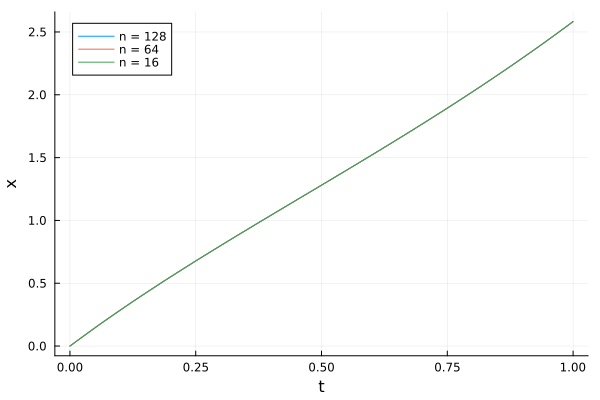

In [15]:
rangs16  = range(0, stop=1, length=length(sol16))
rangs64  = range(0, stop=1, length=length(sol64))
rangs128 = range(0, stop=1, length=length(sol128))

plot(rangs128, sol128, xlabel="t", ylabel="x", label="n = 128")
plot!(rangs64, sol64, label="n = 64")
plot!(rangs16, sol16, label="n = 16")

### Question 3: Comparer à la solution exacte

La solution exacte est $x(t)=e^t - e^{-2t}$ et la valeur optimale est $e^3 - 2e^{-3}+1$.

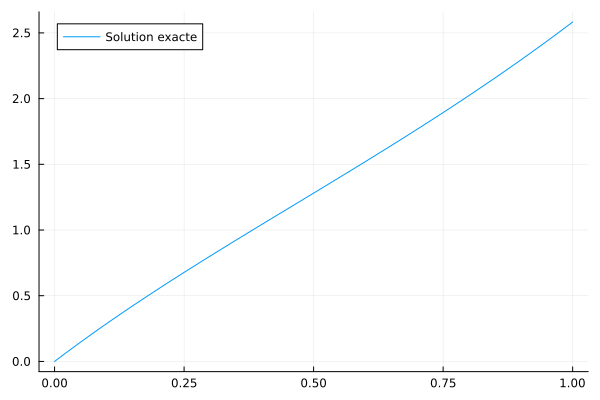

In [19]:
f = t -> exp(t) - exp(-2t)

solexacte = [f(t) for t ∈ rangs128]

# plot(rangs128, sol128, xlabel="t", ylabel="x", label="n = 128")
# plot!(rangs64, sol64, label="n = 64")
# plot!(rangs16, sol16, label="n = 16")
# plot!(rangs128, solexacte, label="Solution exacte")
plot!(rangs128, solexacte, label="Solution exacte")